In [1]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [3]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import matplotlib
matplotlib.rc('font', **{'family': 'serif', 'serif': ['Computer Modern']})
matplotlib.rcParams['text.usetex'] = True
#matplotlib.rcParams['text.latex.unicode'] = True
matplotlib.rcParams['figure.dpi'] = 150

import matplotlib.pyplot as plt
matplotlib.rcParams.update({'figure.autolayout': True})

import seaborn as sns
sns.set(
    style='whitegrid',
    font_scale=0.9,
    rc={'lines.linewidth': 1.4, 'lines.markersize': 1.6},
    font='serif',
)
from jupyterthemes import jtplot
jtplot.style(theme='oceans16')
jtplot.style(context='notebook', fscale=1, spines=False, gridlines='--')
from mpl_toolkits import mplot3d

In [4]:
import numpy as np
from sklearn.gaussian_process.kernels import Matern
import maszcal.twohalo
import maszcal.emulate
import maszcal.interp_utils
import maszcal.interpolate
import maszcal.cosmology
import maszcal.corrections
import supercubos
import projector
import pality

In [5]:
#zs = np.linspace(0, 1, 24)
#mus = np.linspace(np.log(0.3e14), np.log(5e14), 24)

param_mins = np.array([0, np.log(1e13)])
param_maxes = np.array([1.2, np.log(1e15)])

sample = supercubos.LatinSampler().get_lh_sample(
    param_mins=param_mins,
    param_maxes=param_maxes,
    num_samples=600,
)

zs, mus = sample.T

sort_index = zs.argsort()
inverse_index = sort_index.argsort()
zs = zs[sort_index]
mus = mus[sort_index]

cosmo_params = maszcal.cosmology.CosmoParams()

two_halo = maszcal.twohalo.TwoHaloShearModel(
    cosmo_params=cosmo_params,
)

In [6]:
rs = np.logspace(-1, np.log10(40), 40)
esds_2h = two_halo.esd(rs, mus, zs)
esds_2h = esds_2h[inverse_index, :]

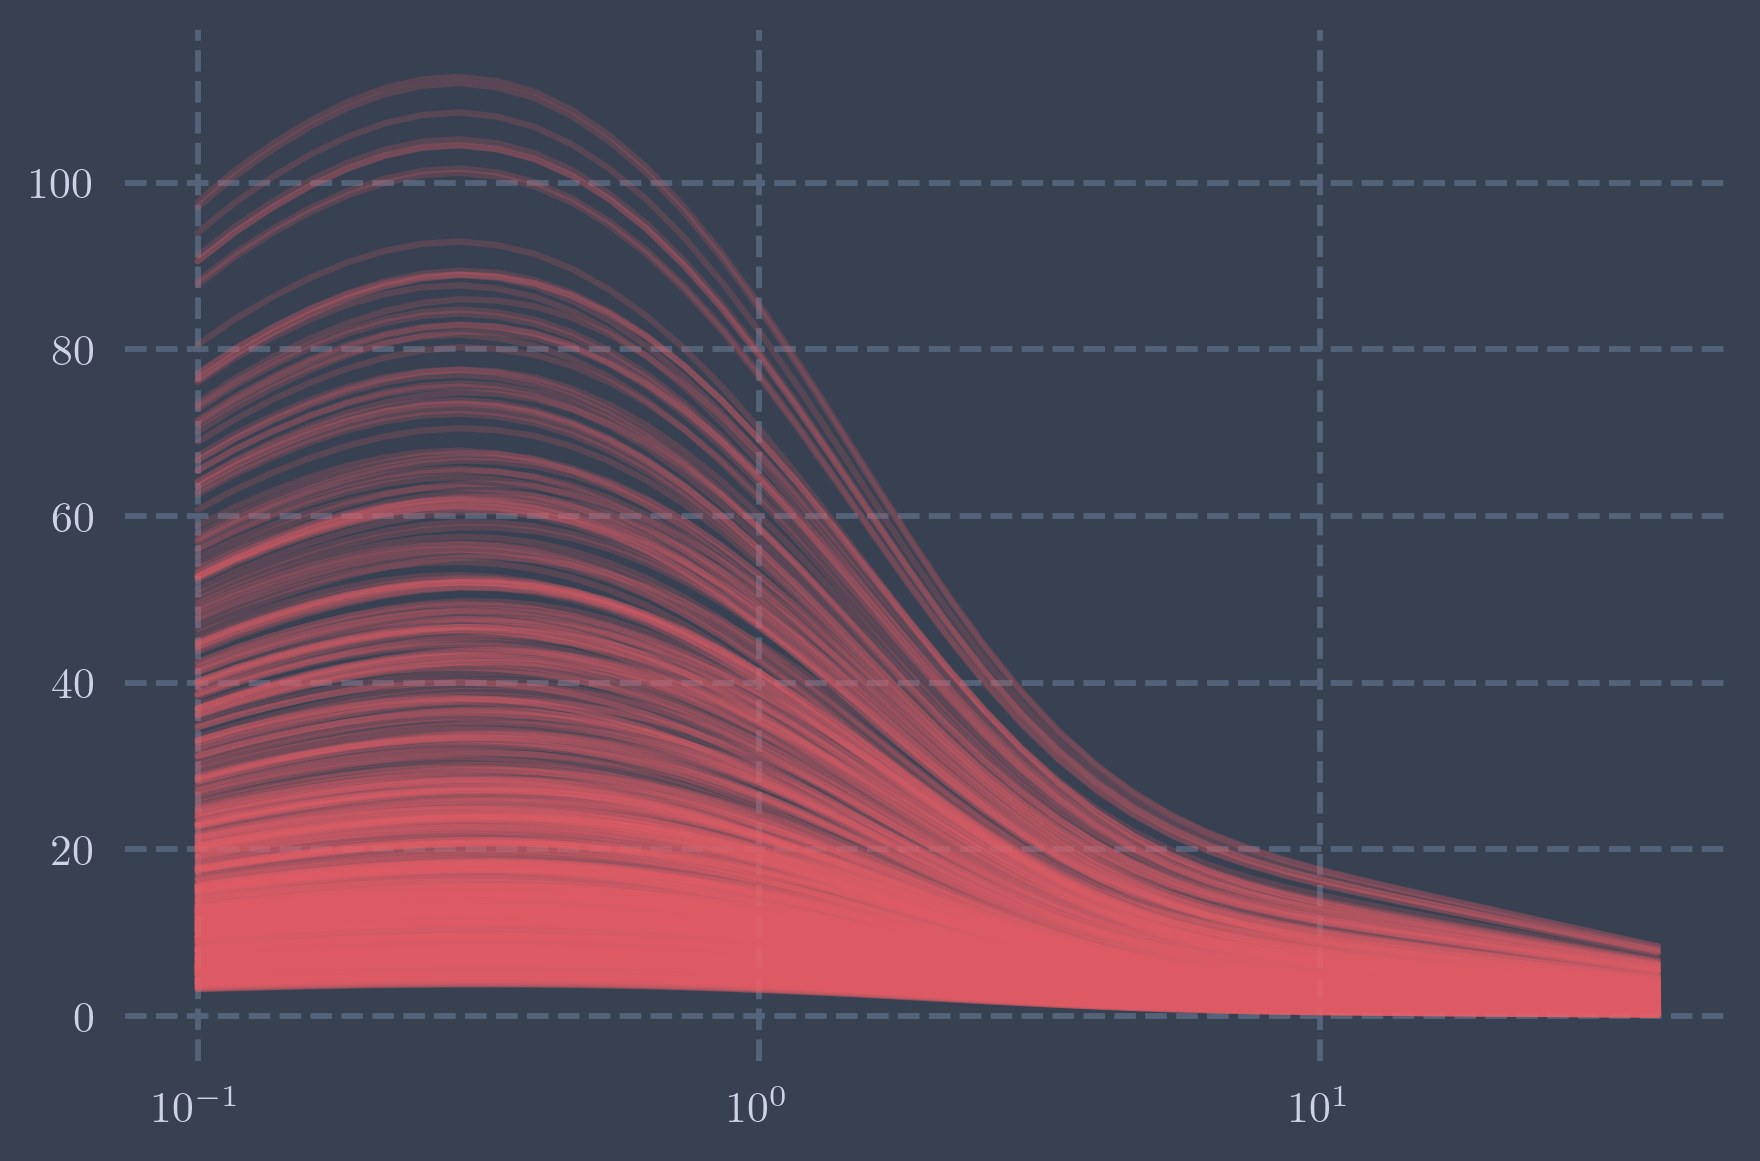

In [7]:
colors = ['#e25f69', '#77be4a', '#5794e4', '#c0af47', '#63c08d', '#d58040']

plt.plot(rs, esds_2h.T, alpha=0.2, color=colors[0], linestyle='-')
plt.gcf().set_size_inches(6, 4)
plt.xscale('log')

In [8]:
emulator = maszcal.emulate.PcaEmulator.create_from_data(
    sample,
    esds_2h.T,
    interpolator_class=maszcal.interpolate.RbfInterpolator,
    num_components=6
)

In [9]:
emulator.explained_variance.sum()

0.9999999999348774

In [20]:
sample_test = supercubos.LatinSampler().get_rand_sample(
    param_mins=param_mins,
    param_maxes=param_maxes,
    num_samples=1000,
)
zs_test, mus_test = sample_test.T

sort_index_test = zs_test.argsort()
inverse_index_test = sort_index_test.argsort()
zs_test = zs_test[sort_index_test]
mus_test = mus_test[sort_index_test]

two_halo = maszcal.twohalo.TwoHaloShearModel(
    cosmo_params=cosmo_params,
)
esds_2h_test = two_halo.esd(rs, mus_test, zs_test)
esds_2h_test = esds_2h_test[inverse_index_test, :]

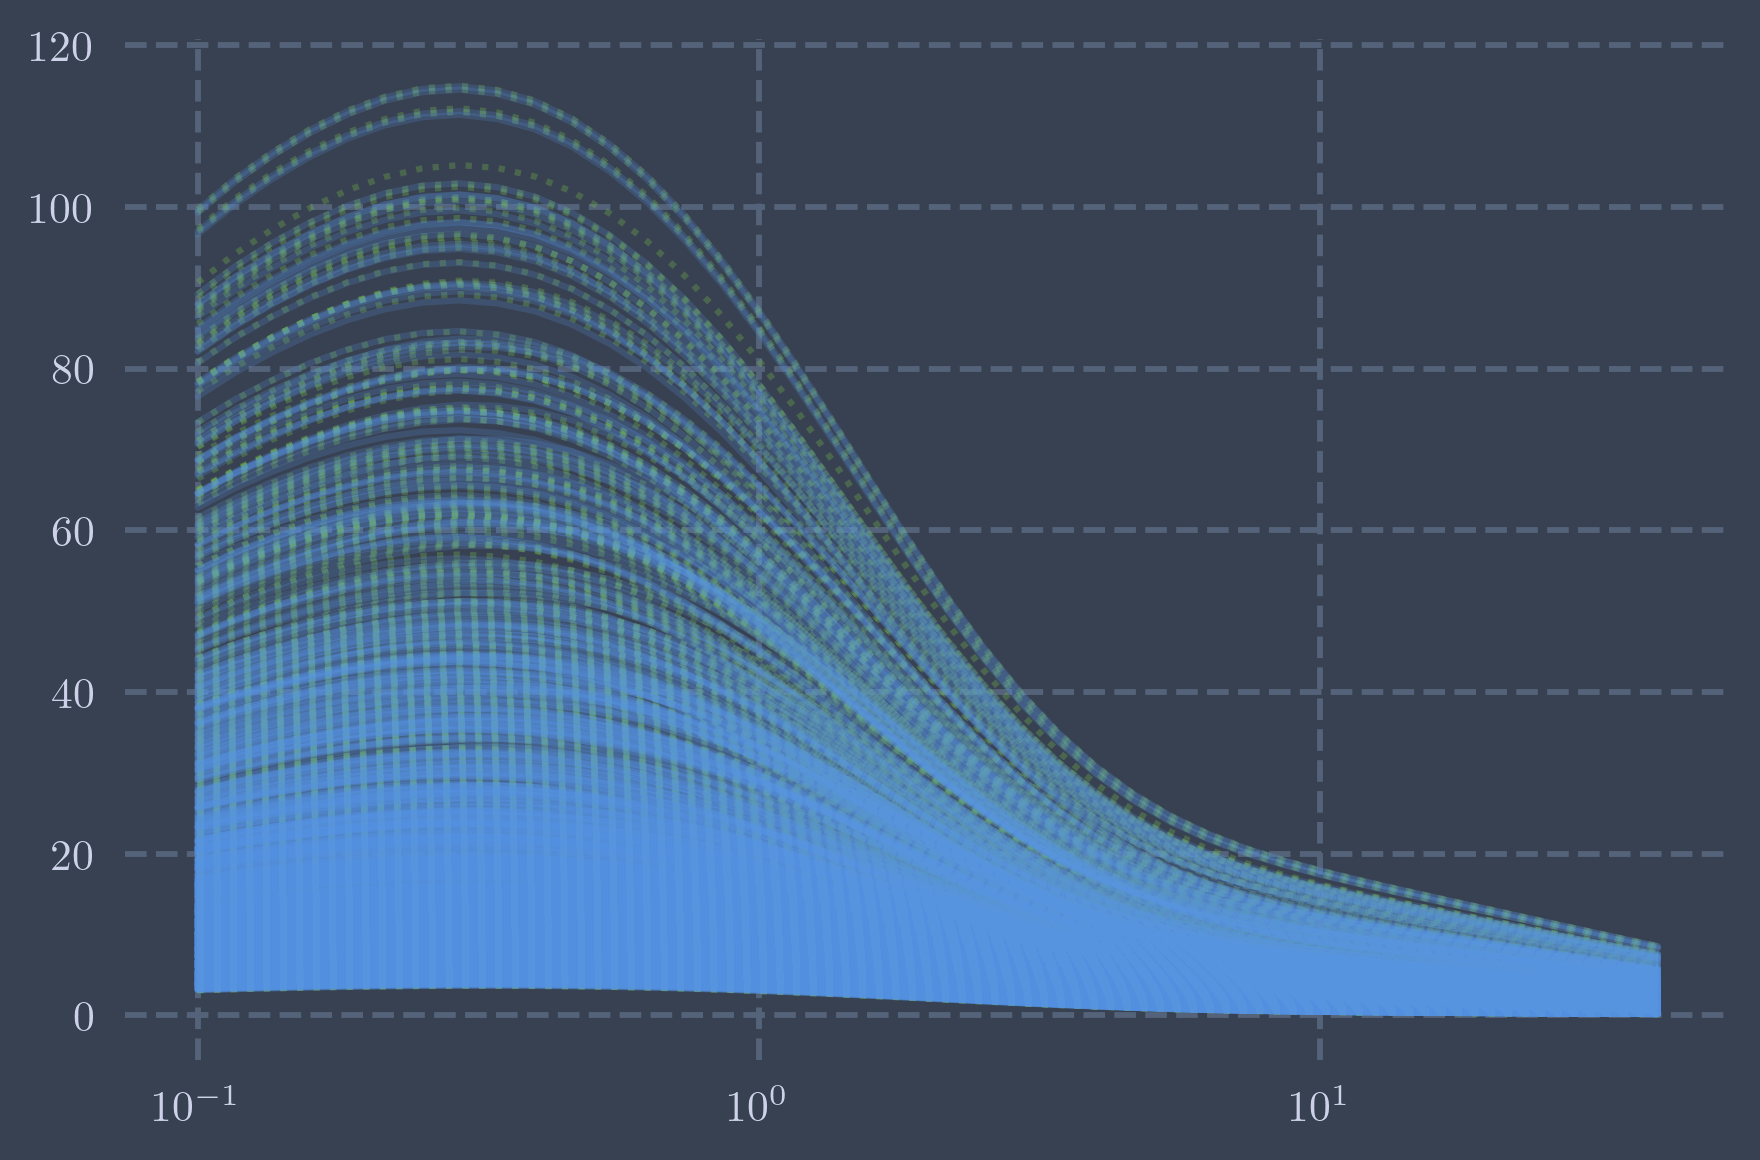

In [40]:
plt.plot(rs, esds_2h_test.T, alpha=0.3, color=colors[1], linestyle=':')
plt.plot(rs, emulator(sample_test), alpha=0.2, color=colors[2])
#plt.plot(rs, data_test.T, alpha=0.8, color='grey', linestyle='--')
plt.gcf().set_size_inches(6, 4)
plt.xscale('log')

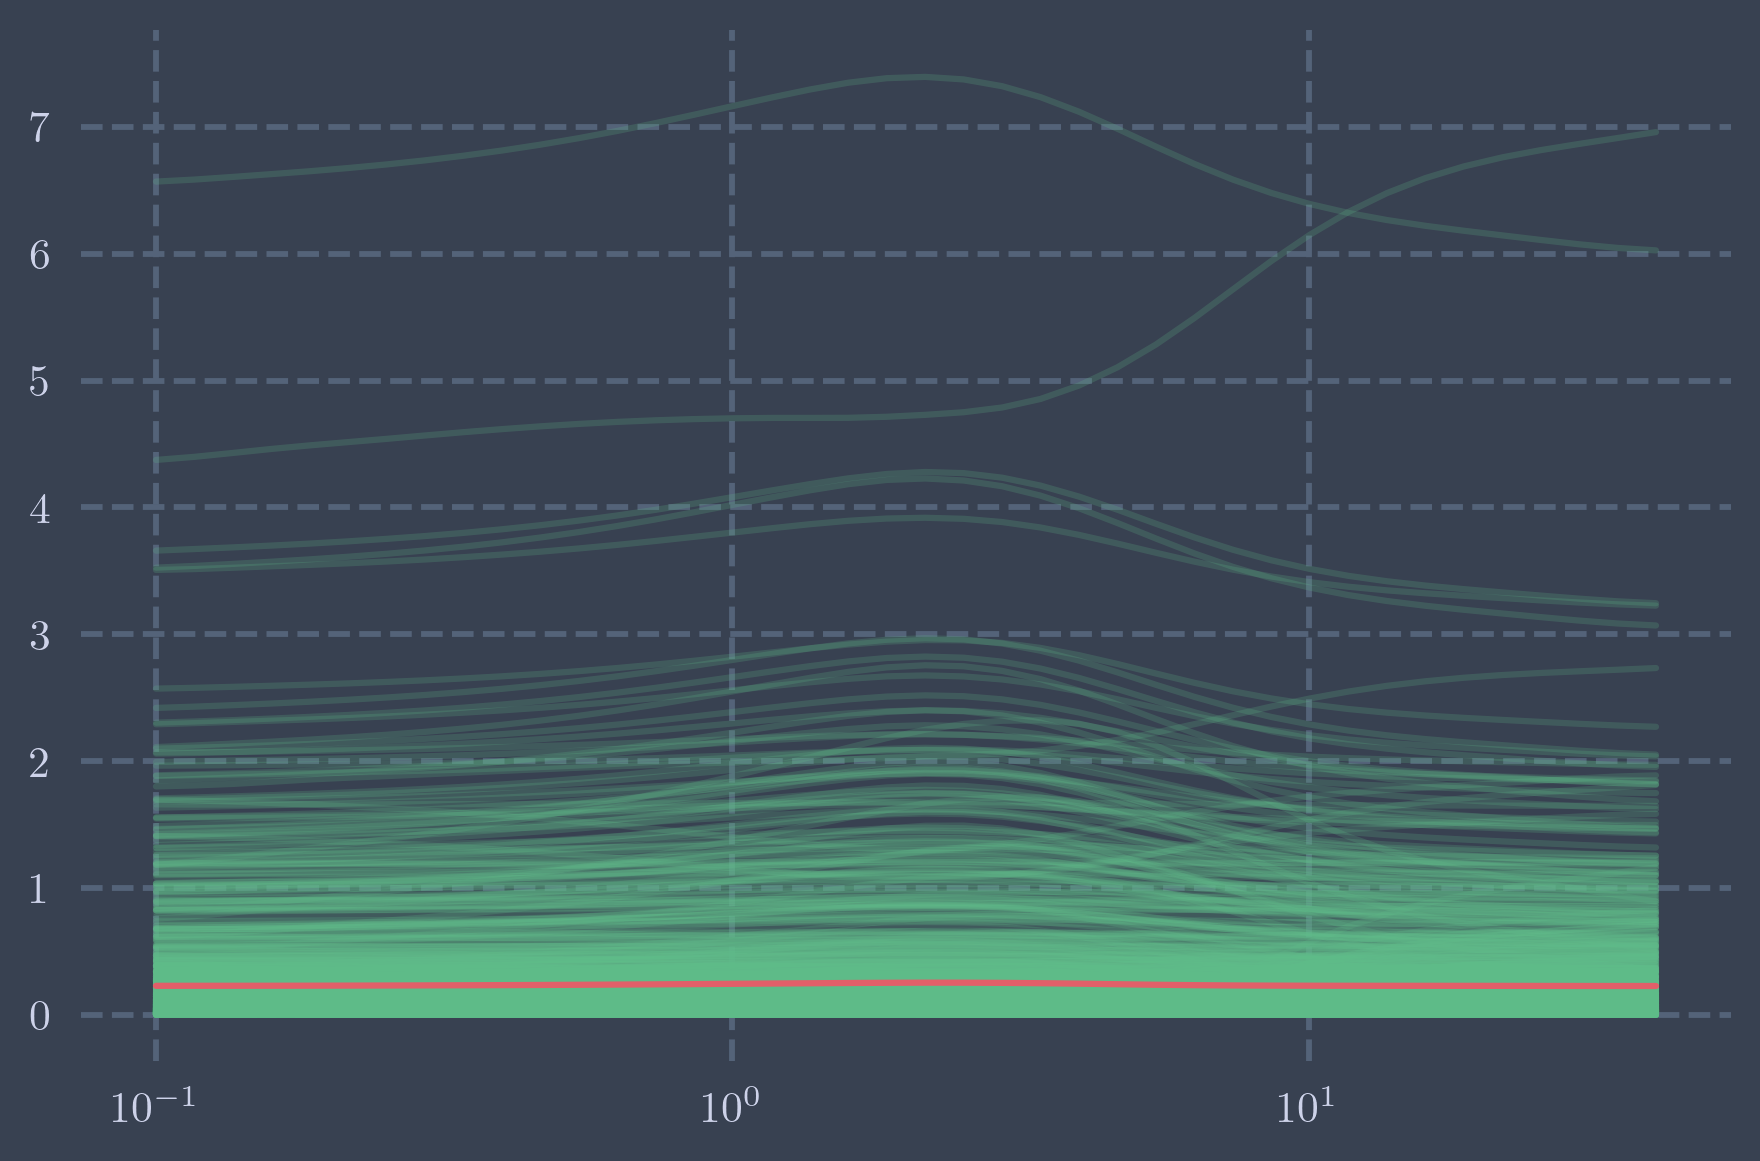

In [22]:
err = (emulator(sample_test).T - esds_2h_test)/esds_2h_test
plt.plot(rs, 100*np.abs(err.T), alpha=0.2, color=colors[4])
plt.plot(rs, 100*np.abs(err.T).mean(axis=-1), alpha=1, color=colors[0])
plt.gcf().set_size_inches(6, 4)
plt.xscale('log')

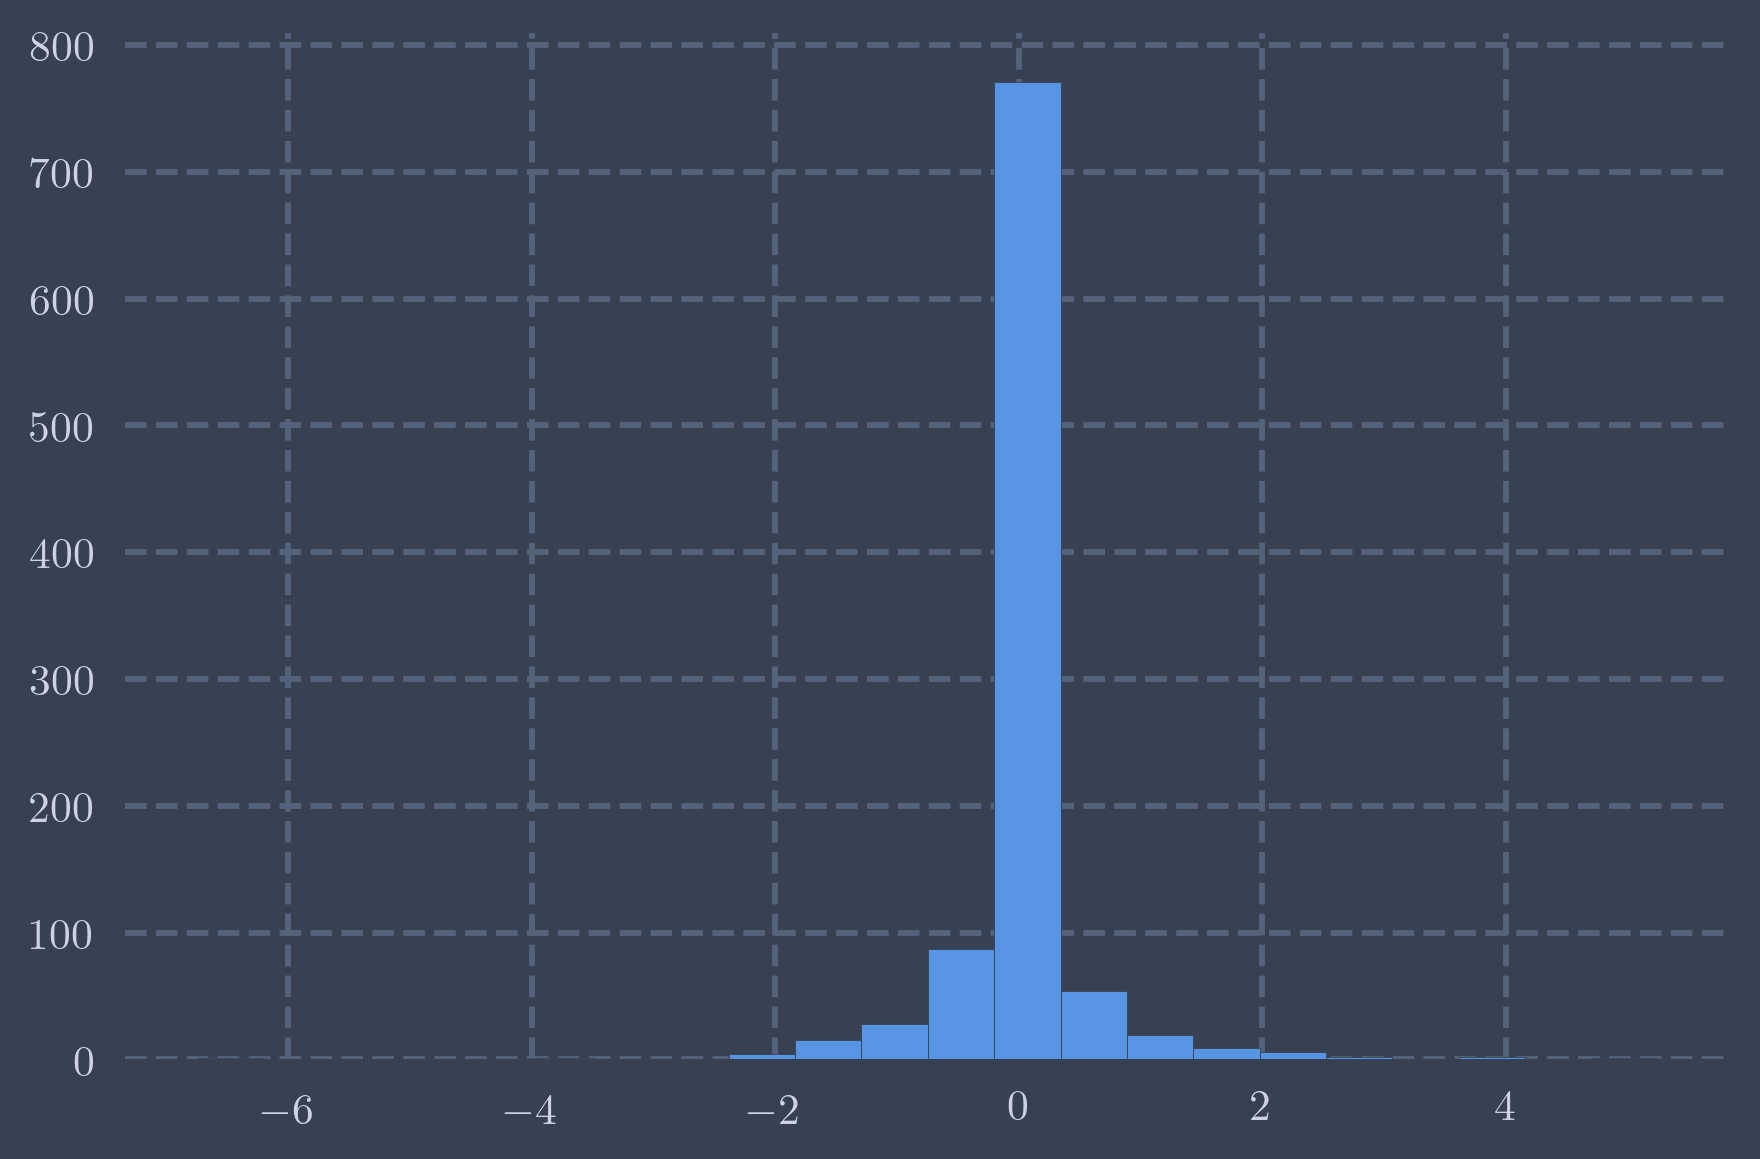

In [42]:
plt.hist(100*err.mean(axis=-1), color=colors[2], bins=22)
plt.gcf().set_size_inches(6, 4)

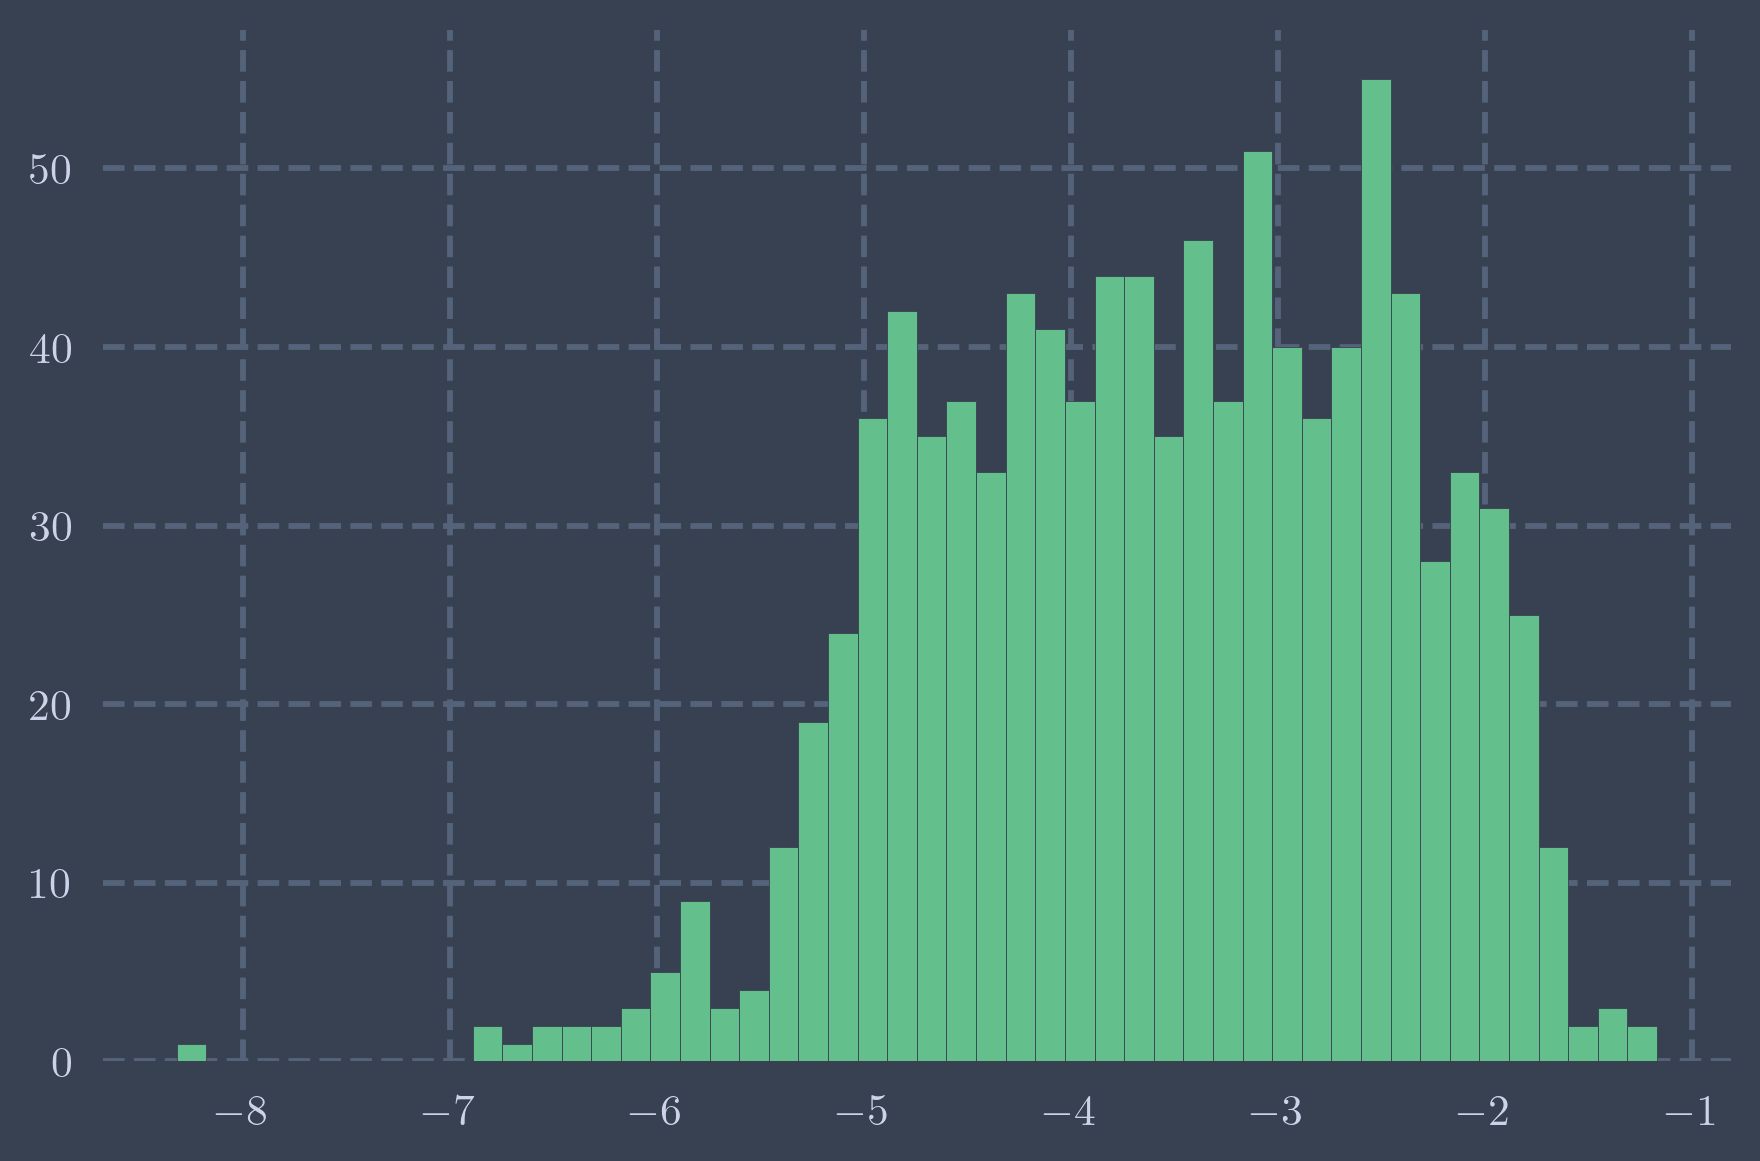

In [50]:
plt.hist(np.log10(np.abs(err.mean(axis=-1))), color=colors[4], bins=50)
plt.gcf().set_size_inches(6, 4)

In [51]:
mean_abs_err = np.abs(err.mean(axis=-1))
100*mean_abs_err[100*mean_abs_err>1].size/mean_abs_err.size

7.3

In [52]:
N_CLUSTERS = 200
zs_test = 0.8*np.random.rand(N_CLUSTERS)
mus_test = (mus[-2] - mus[1])*np.random.rand(N_CLUSTERS) + mus[1]
sz_masses = np.exp(mus_test)
cluster_zs = zs_test
lensing_weights = 1 + 0.1*np.random.randn(N_CLUSTERS)

In [73]:
zs_, mus_ = sample.T
assert np.all(np.stack((zs_, mus_)) == sample.T)

In [83]:
def emu(zs, mus):
    return emulator(np.stack((zs, mus)).T).T

In [84]:
model = maszcal.corrections.Matching2HaloBaryonShearModel(
    radii=rs,
    sz_masses=sz_masses,
    redshifts=cluster_zs,
    lensing_weights=lensing_weights,
    two_halo_term_function=lambda zs, mus: emu(zs, mus),
    delta=500,
    mass_definition='crit',
)

In [85]:
cons = 3*np.ones(15)
alphas = 0.9*np.ones(15)
betas = 3.8*np.ones(15)
gammas = 0.2*np.ones(15)
a_2hs = np.linspace(0, 1, 15)
a_szs = np.array([0])

In [86]:
esds = model.stacked_delta_sigma(cons, alphas, betas, gammas, a_2hs, a_szs)

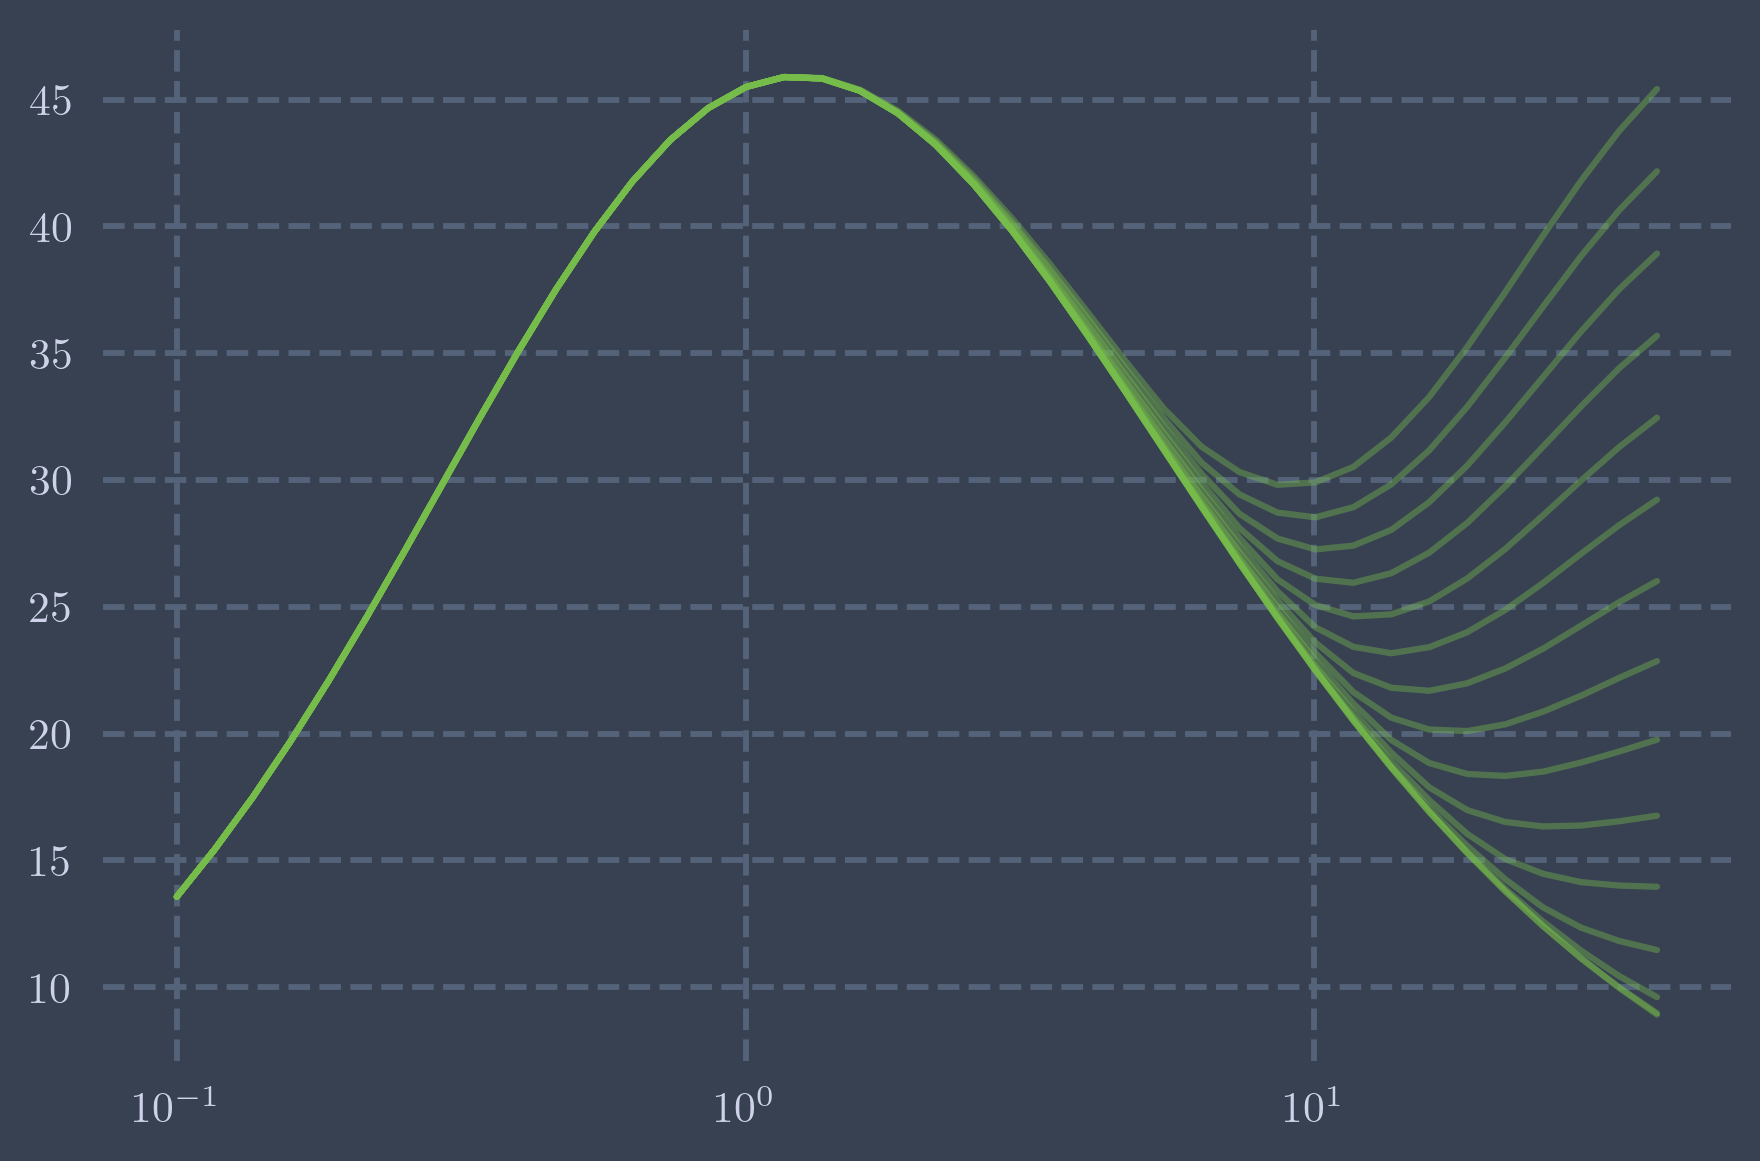

In [89]:
plt.plot(rs, rs[:, None]*esds.squeeze(), color=colors[1], alpha=0.4)
plt.xscale('log')
plt.gcf().set_size_inches(6, 4)
pass